# The Representation-Reasoning Gap
**Language Models Encode Spatial Relations They Fail to Reason Over**

This notebook implements the full experimental pipeline:
1. Synthesize 2,500 grid-world navigation scenarios
2. Evaluate model behavioral accuracy (greedy decoding)
3. Extract residual stream activations at key token positions
4. Train linear probes to decode spatial position from activations
5. Quantify the representation-reasoning gap across step counts and model scales

## 0. Setup & Imports

In [1]:
# Install dependencies - after running this cell, restart the runtime
# (Runtime → Restart runtime), then skip this cell and run from the imports cell onward.
!pip install transformer_lens transformers torch scikit-learn matplotlib seaborn scipy tqdm ipywidgets -q
!pip install numpy==1.26.4 -q  # pin numpy to version compatible with Colab's pre-compiled packages

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.2/195.2 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 122.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 90.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rasterio 1.5.0 requires numpy>=2, but you have numpy 1.26.4 which i

In [1]:
import random
import re
import gc
import os
import warnings
from collections import defaultdict
from typing import Dict, List, Tuple, Optional

import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, top_k_accuracy_score
from tqdm.auto import tqdm

import transformer_lens
from transformer_lens import HookedTransformer

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device
if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"
print(f"Using device: {DEVICE}")

# Grid-world constants
GRID_SIZE = 5
DIRECTIONS = {
    "north": (-1, 0),
    "south": (1, 0),
    "east": (0, 1),
    "west": (0, -1),
}
DIRECTION_NAMES = list(DIRECTIONS.keys())
STEP_COUNTS = [1, 2, 3, 4, 5]
NUM_SCENARIOS_PER_STEP = 500

# Model configurations
MODEL_CONFIGS = {
    "gpt2-medium": {
        "tl_name": "gpt2-medium",
        "n_layers": 24,
        "d_model": 1024,
        "dtype": torch.float32,
        "batch_size": 16,
        "description": "GPT-2 Medium (355M)",
    },
}

# Plot style
sns.set_style("whitegrid")
plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
})

FIGURES_DIR = "paper/figures"
os.makedirs(FIGURES_DIR, exist_ok=True)

tl_version = getattr(transformer_lens, '__version__', 'unknown')
print(f"Transformer Lens version: {tl_version}")
print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")

Using device: cuda
Transformer Lens version: unknown
PyTorch version: 2.9.0+cu128
NumPy version: 1.26.4


## 1. Data Generation

In [2]:
def generate_scenario(num_steps: int, rng: random.Random) -> dict:
    """Generate a single grid-world navigation scenario.

    Samples a random start position, then num_steps random valid moves.
    Moves that would go off-grid are rejected and resampled.

    Returns dict with start_pos, moves, intermediate_positions, final_pos, prompt.
    """
    start_row = rng.randint(0, GRID_SIZE - 1)
    start_col = rng.randint(0, GRID_SIZE - 1)

    current_row, current_col = start_row, start_col
    moves = []
    intermediate_positions = []  # position AFTER each move

    for _ in range(num_steps):
        # Sample a valid move (reject off-grid moves)
        valid_dirs = []
        for d_name, (dr, dc) in DIRECTIONS.items():
            nr, nc = current_row + dr, current_col + dc
            if 0 <= nr < GRID_SIZE and 0 <= nc < GRID_SIZE:
                valid_dirs.append(d_name)

        direction = rng.choice(valid_dirs)
        dr, dc = DIRECTIONS[direction]
        current_row += dr
        current_col += dc

        moves.append(direction)
        intermediate_positions.append((current_row, current_col))

    prompt = build_prompt(start_row, start_col, moves)

    return {
        "start_pos": (start_row, start_col),
        "moves": moves,
        "intermediate_positions": intermediate_positions,
        "final_pos": (current_row, current_col),
        "prompt": prompt,
        "num_steps": num_steps,
    }


def build_prompt(start_row: int, start_col: int, moves: List[str]) -> str:
    """Build the prompt string from the exact template in CLAUDE.md."""
    lines = [
        f"Consider a 5x5 grid where positions are labeled (row, col) with (0,0) at the top-left and (4,4) at the bottom-right. "
        f"Moving north decreases the row by 1, south increases the row by 1, east increases the column by 1, and west decreases the column by 1.",
        "",
        f"An agent starts at position ({start_row}, {start_col}).",
        "",
    ]
    for i, direction in enumerate(moves, 1):
        lines.append(f"Step {i}: The agent moves {direction}.")
    lines.append("")
    lines.append("What is the agent's current position? The answer is (")
    return "\n".join(lines)


def validate_scenario(scenario: dict) -> bool:
    """Independently re-simulate a scenario and verify all positions."""
    row, col = scenario["start_pos"]
    for i, direction in enumerate(scenario["moves"]):
        dr, dc = DIRECTIONS[direction]
        row += dr
        col += dc
        if (row, col) != scenario["intermediate_positions"][i]:
            return False
        if not (0 <= row < GRID_SIZE and 0 <= col < GRID_SIZE):
            return False
    if (row, col) != scenario["final_pos"]:
        return False
    return True


# Generate all scenarios
rng = random.Random(SEED)
scenarios: Dict[int, List[dict]] = {}

for n_steps in STEP_COUNTS:
    scenarios[n_steps] = []
    for _ in range(NUM_SCENARIOS_PER_STEP):
        s = generate_scenario(n_steps, rng)
        scenarios[n_steps].append(s)

total = sum(len(v) for v in scenarios.values())
print(f"Generated {total} scenarios total")
for n in STEP_COUNTS:
    print(f"  N={n}: {len(scenarios[n])} scenarios")

# Validate all scenarios
all_valid = True
for n_steps, scene_list in scenarios.items():
    for s in scene_list:
        if not validate_scenario(s):
            print(f"VALIDATION FAILED for scenario with {n_steps} steps!")
            all_valid = False
            break
if all_valid:
    print("All 2,500 scenarios passed independent re-simulation validation.")

Generated 2500 scenarios total
  N=1: 500 scenarios
  N=2: 500 scenarios
  N=3: 500 scenarios
  N=4: 500 scenarios
  N=5: 500 scenarios
All 2,500 scenarios passed independent re-simulation validation.


In [3]:
# Report position distributions
# Check for boundary effects: corners/edges may be underrepresented as final positions
print("Final position distribution by step count:")
for n_steps in STEP_COUNTS:
    pos_counts = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
    for s in scenarios[n_steps]:
        r, c = s["final_pos"]
        pos_counts[r, c] += 1
    print(f"\nN={n_steps} — min: {pos_counts.min()}, max: {pos_counts.max()}, "
          f"std: {pos_counts.std():.1f}, corners: {pos_counts[0,0]+pos_counts[0,4]+pos_counts[4,0]+pos_counts[4,4]}")

# Overall starting position distribution (should be ~uniform)
start_counts = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
for n_steps in STEP_COUNTS:
    for s in scenarios[n_steps]:
        r, c = s["start_pos"]
        start_counts[r, c] += 1
print(f"\nStarting position distribution — min: {start_counts.min()}, max: {start_counts.max()}, "
      f"std: {start_counts.std():.1f}")

# Print example prompts
print("\n" + "="*60)
print("Example prompt (N=1):")
print(scenarios[1][0]["prompt"])
print(f"Ground truth: {scenarios[1][0]['final_pos']}")
print("\n" + "="*60)
print("Example prompt (N=5):")
print(scenarios[5][0]["prompt"])
print(f"Ground truth: {scenarios[5][0]['final_pos']}")

Final position distribution by step count:

N=1 — min: 11, max: 37, std: 6.0, corners: 54

N=2 — min: 11, max: 33, std: 5.5, corners: 61

N=3 — min: 12, max: 31, std: 5.2, corners: 54

N=4 — min: 9, max: 34, std: 6.6, corners: 49

N=5 — min: 10, max: 37, std: 6.6, corners: 58

Starting position distribution — min: 87, max: 113, std: 7.1

Example prompt (N=1):
Consider a 5x5 grid where positions are labeled (row, col) with (0,0) at the top-left and (4,4) at the bottom-right. Moving north decreases the row by 1, south increases the row by 1, east increases the column by 1, and west decreases the column by 1.

An agent starts at position (0, 0).

Step 1: The agent moves east.

What is the agent's current position? The answer is (
Ground truth: (0, 1)

Example prompt (N=5):
Consider a 5x5 grid where positions are labeled (row, col) with (0,0) at the top-left and (4,4) at the bottom-right. Moving north decreases the row by 1, south increases the row by 1, east increases the column by 1, and

## 2. Behavioral Evaluation

In [4]:
def parse_predicted_position(text: str) -> Optional[Tuple[int, int]]:
    """Extract the first (row, col) pattern from model output text.

    Handles formats like: (2, 3), (2,3), 2, 3), etc.
    The prompt ends with 'The answer is (' so model output likely starts with 'X, Y)'
    """
    # Try to match (X, Y) or X, Y) since we already provided the opening paren
    match = re.search(r'(\d)\s*,\s*(\d)', text)
    if match:
        row, col = int(match.group(1)), int(match.group(2))
        if 0 <= row < GRID_SIZE and 0 <= col < GRID_SIZE:
            return (row, col)
    return None


def find_direction_token_positions(
    prompt: str,
    model: HookedTransformer,
    moves: List[str]
) -> Tuple[List[int], int]:
    """Find the token positions corresponding to each direction word in the step instructions.

    Uses character-to-token offset mapping to robustly handle sub-word tokenization.
    Only matches direction words inside 'Step N: The agent moves {direction}.' lines
    to avoid matching direction words in the preamble.

    Returns:
        direction_positions: list of token indices (one per step), pointing to the
            last sub-token of each direction word (model has fully processed the move)
        final_token_pos: index of the last token in the prompt (the opening paren)
    """
    tokens = model.to_tokens(prompt, prepend_bos=True)[0]  # shape: [seq_len]
    str_tokens = model.to_str_tokens(prompt, prepend_bos=True)

    # Build character offset -> token index mapping
    # TransformerLens str_tokens includes BOS as first token
    char_to_token = {}
    current_char = 0
    for tok_idx, tok_str in enumerate(str_tokens):
        if tok_idx == 0 and tok_str in ['<|endoftext|>', '<s>', '<bos>']:
            # BOS token doesn't correspond to any prompt characters
            continue
        for j in range(len(tok_str)):
            char_to_token[current_char + j] = tok_idx
        current_char += len(tok_str)

    direction_positions = []
    for step_idx, direction in enumerate(moves, 1):
        # Search for the full step pattern to avoid preamble false matches
        pattern = f"Step {step_idx}: The agent moves {direction}."
        char_idx = prompt.find(pattern)
        assert char_idx != -1, f"Could not find '{pattern}' in prompt"

        # Find the last character of the direction word within this pattern
        dir_start_in_pattern = pattern.find(direction)
        dir_last_char = char_idx + dir_start_in_pattern + len(direction) - 1

        # Map to token index (last sub-token of the direction word)
        tok_idx = char_to_token.get(dir_last_char)
        assert tok_idx is not None, (
            f"Character offset {dir_last_char} not found in char_to_token map. "
            f"Prompt length: {len(prompt)}, map covers: 0-{max(char_to_token.keys())}"
        )
        direction_positions.append(tok_idx)

    final_token_pos = len(str_tokens) - 1

    return direction_positions, final_token_pos


def verify_token_positions(model: HookedTransformer, scenarios: Dict[int, List[dict]],
                           model_name: str):
    """Print token context around identified direction positions for manual verification."""
    print(f"\n{'='*60}")
    print(f"Token position verification for {model_name}")
    print(f"{'='*60}")

    for n_steps in [1, 3, 5]:
        s = scenarios[n_steps][0]
        str_tokens = model.to_str_tokens(s["prompt"], prepend_bos=True)
        dir_positions, final_pos = find_direction_token_positions(
            s["prompt"], model, s["moves"]
        )

        print(f"\nN={n_steps}, moves={s['moves']}")
        for step_i, pos in enumerate(dir_positions):
            context_start = max(0, pos - 3)
            context_end = min(len(str_tokens), pos + 3)
            context = str_tokens[context_start:context_end]
            pointer_idx = pos - context_start
            print(f"  Step {step_i+1} ('{s['moves'][step_i]}') -> token {pos}: "
                  f"{context}  [arrow at index {pointer_idx}]")
        print(f"  Final token pos: {final_pos} -> '{str_tokens[final_pos]}'")

In [6]:
def evaluate_behavioral(
    model: HookedTransformer,
    scenarios: Dict[int, List[dict]],
    max_new_tokens: int = 10
) -> Dict[int, dict]:
    """Run greedy decoding on all scenarios and compute behavioral accuracy per step count.

    Returns dict mapping step_count -> {accuracy, correct, total, predictions}.
    """
    results = {}

    for n_steps in STEP_COUNTS:
        correct = 0
        total = len(scenarios[n_steps])
        predictions = []

        for s in tqdm(scenarios[n_steps], desc=f"Behavioral eval N={n_steps}"):
            tokens = model.to_tokens(s["prompt"], prepend_bos=True)

            # Greedy decoding
            generated = model.generate(
                tokens,
                max_new_tokens=max_new_tokens,
                temperature=0.0,
                do_sample=False,
                verbose=False,
            )

            # Decode only the newly generated tokens
            new_tokens = generated[0, tokens.shape[1]:]
            output_text = model.to_string(new_tokens)

            pred = parse_predicted_position(output_text)
            predictions.append(pred)

            if pred == s["final_pos"]:
                correct += 1

        acc = correct / total
        results[n_steps] = {
            "accuracy": acc,
            "correct": correct,
            "total": total,
            "predictions": predictions,
        }
        print(f"  N={n_steps}: {acc:.1%} ({correct}/{total})")

    return results

## 3. Activation Extraction

In [7]:
def extract_activations(
    model: HookedTransformer,
    scenarios: Dict[int, List[dict]],
    n_layers: int,
    d_model: int,
) -> Tuple[Dict[int, np.ndarray], Dict[int, np.ndarray]]:
    """Extract residual stream activations at direction token positions and final token.

    Uses TransformerLens run_with_cache with names_filter to only cache
    residual stream post-layer outputs, stored on CPU.

    Returns:
        step_activations: dict mapping n_steps -> array of shape
            (num_scenarios, n_layers, n_steps, d_model)
        final_activations: dict mapping n_steps -> array of shape
            (num_scenarios, n_layers, d_model)
    """
    step_activations = {}
    final_activations = {}

    for n_steps in STEP_COUNTS:
        n_scenarios = len(scenarios[n_steps])
        step_acts = np.zeros((n_scenarios, n_layers, n_steps, d_model), dtype=np.float32)
        final_acts = np.zeros((n_scenarios, n_layers, d_model), dtype=np.float32)

        for i, s in enumerate(tqdm(scenarios[n_steps], desc=f"Activations N={n_steps}")):
            tokens = model.to_tokens(s["prompt"], prepend_bos=True)
            dir_positions, final_pos = find_direction_token_positions(
                s["prompt"], model, s["moves"]
            )

            # Run forward pass and cache residual stream outputs
            with torch.no_grad():
                _, cache = model.run_with_cache(
                    tokens,
                    names_filter=lambda name: "hook_resid_post" in name,
                    device="cpu",
                )

            for layer_idx in range(n_layers):
                # Cache key: blocks.{layer}.hook_resid_post -> [1, seq_len, d_model]
                resid = cache[f"blocks.{layer_idx}.hook_resid_post"][0]  # [seq_len, d_model]

                for step_j, tok_pos in enumerate(dir_positions):
                    step_acts[i, layer_idx, step_j] = resid[tok_pos].numpy()

                final_acts[i, layer_idx] = resid[final_pos].numpy()

            del cache
            if i % 50 == 0:
                gc.collect()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        step_activations[n_steps] = step_acts
        final_activations[n_steps] = final_acts

        # Validate shapes and values
        assert step_acts.shape == (n_scenarios, n_layers, n_steps, d_model), \
            f"Shape mismatch: {step_acts.shape}"
        assert final_acts.shape == (n_scenarios, n_layers, d_model), \
            f"Shape mismatch: {final_acts.shape}"
        assert not np.any(np.isnan(step_acts)), "NaN in step activations!"
        assert not np.any(np.isinf(step_acts)), "Inf in step activations!"
        assert np.std(step_acts) > 0, "Zero variance in step activations!"

        mem_mb = (step_acts.nbytes + final_acts.nbytes) / 1e6
        print(f"  N={n_steps}: step_acts {step_acts.shape}, final_acts {final_acts.shape}, "
              f"{mem_mb:.1f} MB")

    return step_activations, final_activations

## 4. Probing Analysis

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier


def position_to_label(row: int, col: int) -> int:
    """Encode (row, col) as single integer 0-24 for 25-class classification."""
    return row * GRID_SIZE + col


def label_to_position(label: int) -> Tuple[int, int]:
    """Decode single integer back to (row, col)."""
    return divmod(label, GRID_SIZE)


def train_probe(X_train, y_train, X_test, y_test) -> dict:
    """Train a linear probe and return accuracy metrics.

    Uses RidgeClassifier (closed-form solution via ridge regression) which is
    near-instant even when d_model >> n_samples. This is standard for probing
    experiments (equivalent to a linear probe with L2 regularization).
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    clf = RidgeClassifier(alpha=1.0, random_state=SEED)
    clf.fit(X_train_scaled, y_train)

    y_pred = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)

    # Top-3 accuracy via decision function scores
    scores = clf.decision_function(X_test_scaled)  # (n_test, n_classes)
    all_classes = np.arange(GRID_SIZE * GRID_SIZE)

    # Pad scores if some classes are missing
    if scores.ndim == 1:
        # Binary case fallback (shouldn't happen with 25 classes)
        top3_acc = acc
    else:
        if scores.shape[1] < len(all_classes):
            full_scores = np.full((len(y_test), len(all_classes)), -1e9)
            for i, c in enumerate(clf.classes_):
                full_scores[:, c] = scores[:, i]
            scores = full_scores
        # Top-3: check if true label is in top 3 predicted
        top3_preds = np.argsort(scores, axis=1)[:, -3:]
        top3_acc = np.mean([y_test[i] in top3_preds[i] for i in range(len(y_test))])

    return {"accuracy": acc, "top3_accuracy": top3_acc, "clf": clf, "scaler": scaler}


def bootstrap_accuracy(y_true, y_pred, n_bootstrap=1000, ci=0.95) -> Tuple[float, float, float]:
    """Compute bootstrap confidence interval for accuracy."""
    rng = np.random.RandomState(SEED)
    n = len(y_true)
    accs = []
    for _ in range(n_bootstrap):
        idx = rng.choice(n, size=n, replace=True)
        accs.append(accuracy_score(y_true[idx], y_pred[idx]))
    accs = np.array(accs)
    alpha = (1 - ci) / 2
    return np.mean(accs), np.percentile(accs, 100 * alpha), np.percentile(accs, 100 * (1 - alpha))


def run_probing_analysis(
    step_activations: Dict[int, np.ndarray],
    final_activations: Dict[int, np.ndarray],
    scenarios: Dict[int, List[dict]],
    n_layers: int,
) -> dict:
    """Run full probing analysis across all layers and step counts."""
    step_probe_acc = np.zeros((n_layers, len(STEP_COUNTS)))
    step_probe_top3 = np.zeros((n_layers, len(STEP_COUNTS)))
    final_probe_acc = np.zeros((n_layers, len(STEP_COUNTS)))
    final_probe_top3 = np.zeros((n_layers, len(STEP_COUNTS)))
    step_probe_acc_all = {}
    step_probe_ci = {}

    for step_count_idx, n_steps in enumerate(STEP_COUNTS):
        scene_list = scenarios[n_steps]
        n_scenarios = len(scene_list)

        final_labels = np.array([
            position_to_label(*s["final_pos"]) for s in scene_list
        ])

        indices = np.arange(n_scenarios)
        train_idx, test_idx = train_test_split(
            indices, test_size=0.2, random_state=SEED
        )

        for layer_idx in tqdm(range(n_layers), desc=f"Probing N={n_steps}"):
            for step_j in range(n_steps):
                labels_j = np.array([
                    position_to_label(*s["intermediate_positions"][step_j])
                    for s in scene_list
                ])
                X = step_activations[n_steps][:, layer_idx, step_j, :]
                result = train_probe(
                    X[train_idx], labels_j[train_idx],
                    X[test_idx], labels_j[test_idx]
                )
                step_probe_acc_all[(n_steps, layer_idx, step_j)] = result["accuracy"]

            last_step_result = train_probe(
                step_activations[n_steps][train_idx, layer_idx, n_steps - 1, :],
                final_labels[train_idx],
                step_activations[n_steps][test_idx, layer_idx, n_steps - 1, :],
                final_labels[test_idx],
            )
            step_probe_acc[layer_idx, step_count_idx] = last_step_result["accuracy"]
            step_probe_top3[layer_idx, step_count_idx] = last_step_result["top3_accuracy"]

            y_pred = last_step_result["clf"].predict(
                last_step_result["scaler"].transform(
                    step_activations[n_steps][test_idx, layer_idx, n_steps - 1, :]
                )
            )
            ci_result = bootstrap_accuracy(final_labels[test_idx], y_pred)
            step_probe_ci[(n_steps, layer_idx)] = ci_result

            final_result = train_probe(
                final_activations[n_steps][train_idx, layer_idx, :],
                final_labels[train_idx],
                final_activations[n_steps][test_idx, layer_idx, :],
                final_labels[test_idx],
            )
            final_probe_acc[layer_idx, step_count_idx] = final_result["accuracy"]
            final_probe_top3[layer_idx, step_count_idx] = final_result["top3_accuracy"]

    avg_acc_per_layer = step_probe_acc.mean(axis=1)
    peak_layer = int(np.argmax(avg_acc_per_layer))

    print(f"\nPeak probing layer: {peak_layer} (avg accuracy: {avg_acc_per_layer[peak_layer]:.1%})")
    print(f"Step probe accuracy at peak layer: {step_probe_acc[peak_layer]}")
    print(f"Final probe accuracy at peak layer: {final_probe_acc[peak_layer]}")

    return {
        "step_probe_acc": step_probe_acc,
        "step_probe_top3": step_probe_top3,
        "final_probe_acc": final_probe_acc,
        "final_probe_top3": final_probe_top3,
        "step_probe_acc_all": step_probe_acc_all,
        "step_probe_ci": step_probe_ci,
        "peak_layer": peak_layer,
    }

---
## Run Pipeline: GPT-2 Medium (Primary Model)

We run the full pipeline on GPT-2-medium first as it is smallest, fastest, and natively supported by TransformerLens.

In [9]:
# Load GPT-2 Medium
print("Loading GPT-2 Medium...")
model_gpt2 = HookedTransformer.from_pretrained(
    "gpt2-medium",
    device=DEVICE,
)
print(f"Model loaded. Layers: {model_gpt2.cfg.n_layers}, d_model: {model_gpt2.cfg.d_model}")

# Update config with actual values
MODEL_CONFIGS["gpt2-medium"]["n_layers"] = model_gpt2.cfg.n_layers
MODEL_CONFIGS["gpt2-medium"]["d_model"] = model_gpt2.cfg.d_model

Loading GPT-2 Medium...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-medium into HookedTransformer
Model loaded. Layers: 24, d_model: 1024


In [10]:
# Verify token positions
verify_token_positions(model_gpt2, scenarios, "GPT-2 Medium")


Token position verification for GPT-2 Medium

N=1, moves=['east']
  Step 1 ('east') -> token 89: [' The', ' agent', ' moves', ' east', '.', '\n']  [arrow at index 3]
  Final token pos: 104 -> ' ('

N=3, moves=['west', 'west', 'north']
  Step 1 ('west') -> token 89: [' The', ' agent', ' moves', ' west', '.', '\n']  [arrow at index 3]
  Step 2 ('west') -> token 98: [' The', ' agent', ' moves', ' west', '.', '\n']  [arrow at index 3]
  Step 3 ('north') -> token 107: [' The', ' agent', ' moves', ' north', '.', '\n']  [arrow at index 3]
  Final token pos: 122 -> ' ('

N=5, moves=['north', 'north', 'south', 'south', 'east']
  Step 1 ('north') -> token 89: [' The', ' agent', ' moves', ' north', '.', '\n']  [arrow at index 3]
  Step 2 ('north') -> token 98: [' The', ' agent', ' moves', ' north', '.', '\n']  [arrow at index 3]
  Step 3 ('south') -> token 107: [' The', ' agent', ' moves', ' south', '.', '\n']  [arrow at index 3]
  Step 4 ('south') -> token 116: [' The', ' agent', ' moves', ' so

In [11]:
# Debug: inspect what the model actually generates
debug_scenarios = [scenarios[1][0], scenarios[1][1], scenarios[2][0]]
for s in debug_scenarios:
    tokens = model_gpt2.to_tokens(s["prompt"], prepend_bos=True)
    print(f"Prompt ends with: ...{s['prompt'][-40:]!r}")
    print(f"Input tokens shape: {tokens.shape}")
    print(f"Last 5 input tokens: {model_gpt2.to_str_tokens(tokens[0, -5:])}")

    generated = model_gpt2.generate(
        tokens,
        max_new_tokens=10,
        temperature=0.0,
        do_sample=False,
        verbose=False,
    )
    print(f"Generated tokens shape: {generated.shape}")

    # Full generated text (including prompt)
    full_text = model_gpt2.to_string(generated[0])
    print(f"Full output (last 60 chars): ...{full_text[-60:]!r}")

    # Just the new tokens
    new_tokens = generated[0, tokens.shape[1]:]
    new_text = model_gpt2.to_string(new_tokens)
    print(f"New tokens: {model_gpt2.to_str_tokens(new_tokens)}")
    print(f"New text: {new_text!r}")

    pred = parse_predicted_position(new_text)
    print(f"Parsed prediction: {pred}, Ground truth: {s['final_pos']}")
    print("-" * 60)

Prompt ends with: ..."gent's current position? The answer is ("
Input tokens shape: torch.Size([1, 105])
Last 5 input tokens: ['?', ' The', ' answer', ' is', ' (']
Generated tokens shape: torch.Size([1, 115])
Full output (last 60 chars): ..."agent's current position? The answer is (0, 0).\n\nStep 2: The"
New tokens: ['0', ',', ' 0', ').', '\n', '\n', 'Step', ' 2', ':', ' The']
New text: '0, 0).\n\nStep 2: The'
Parsed prediction: (0, 0), Ground truth: (0, 1)
------------------------------------------------------------
Prompt ends with: ..."gent's current position? The answer is ("
Input tokens shape: torch.Size([1, 105])
Last 5 input tokens: ['?', ' The', ' answer', ' is', ' (']
Generated tokens shape: torch.Size([1, 115])
Full output (last 60 chars): ..."agent's current position? The answer is (1, 1).\n\nStep 2: The"
New tokens: ['1', ',', ' 1', ').', '\n', '\n', 'Step', ' 2', ':', ' The']
New text: '1, 1).\n\nStep 2: The'
Parsed prediction: (1, 1), Ground truth: (2, 1)
---------------

In [12]:
# Behavioral evaluation
print("Running behavioral evaluation for GPT-2 Medium...")
behavioral_gpt2 = evaluate_behavioral(model_gpt2, scenarios)

print("\nGPT-2 Medium Behavioral Results:")
for n in STEP_COUNTS:
    b = behavioral_gpt2[n]
    print(f"  N={n}: {b['accuracy']:.1%} ({b['correct']}/{b['total']})")

Running behavioral evaluation for GPT-2 Medium...


Behavioral eval N=1:   0%|          | 0/500 [00:00<?, ?it/s]

  N=1: 0.0% (0/500)


Behavioral eval N=2:   0%|          | 0/500 [00:00<?, ?it/s]

  N=2: 25.2% (126/500)


Behavioral eval N=3:   0%|          | 0/500 [00:00<?, ?it/s]

  N=3: 1.2% (6/500)


Behavioral eval N=4:   0%|          | 0/500 [00:00<?, ?it/s]

  N=4: 18.2% (91/500)


Behavioral eval N=5:   0%|          | 0/500 [00:00<?, ?it/s]

  N=5: 1.8% (9/500)

GPT-2 Medium Behavioral Results:
  N=1: 0.0% (0/500)
  N=2: 25.2% (126/500)
  N=3: 1.2% (6/500)
  N=4: 18.2% (91/500)
  N=5: 1.8% (9/500)


In [13]:
# Activation extraction
print("Extracting activations for GPT-2 Medium...")
step_acts_gpt2, final_acts_gpt2 = extract_activations(
    model_gpt2, scenarios,
    n_layers=model_gpt2.cfg.n_layers,
    d_model=model_gpt2.cfg.d_model,
)

Extracting activations for GPT-2 Medium...


Activations N=1:   0%|          | 0/500 [00:00<?, ?it/s]

  N=1: step_acts (500, 24, 1, 1024), final_acts (500, 24, 1024), 98.3 MB


Activations N=2:   0%|          | 0/500 [00:00<?, ?it/s]

  N=2: step_acts (500, 24, 2, 1024), final_acts (500, 24, 1024), 147.5 MB


Activations N=3:   0%|          | 0/500 [00:00<?, ?it/s]

  N=3: step_acts (500, 24, 3, 1024), final_acts (500, 24, 1024), 196.6 MB


Activations N=4:   0%|          | 0/500 [00:00<?, ?it/s]

  N=4: step_acts (500, 24, 4, 1024), final_acts (500, 24, 1024), 245.8 MB


Activations N=5:   0%|          | 0/500 [00:00<?, ?it/s]

  N=5: step_acts (500, 24, 5, 1024), final_acts (500, 24, 1024), 294.9 MB


In [21]:
# Probing analysis
print("Running probing analysis for GPT-2 Medium...")
probing_gpt2 = run_probing_analysis(
    step_acts_gpt2, final_acts_gpt2, scenarios,
    n_layers=model_gpt2.cfg.n_layers,
)

Running probing analysis for GPT-2 Medium...


Probing N=1:   0%|          | 0/24 [00:00<?, ?it/s]

Probing N=2:   0%|          | 0/24 [00:00<?, ?it/s]

Probing N=3:   0%|          | 0/24 [00:00<?, ?it/s]

Probing N=4:   0%|          | 0/24 [00:00<?, ?it/s]

Probing N=5:   0%|          | 0/24 [00:00<?, ?it/s]


Peak probing layer: 19 (avg accuracy: 46.8%)
Step probe accuracy at peak layer: [0.98 0.67 0.34 0.18 0.17]
Final probe accuracy at peak layer: [0.88 0.59 0.4  0.37 0.39]


## 5. Ablation A: Step Count Sweep (Main Result)

In [22]:
def ablation_a_table(behavioral: dict, probing: dict, model_name: str):
    """Print table: behavioral acc vs probe acc vs gap, per step count."""
    peak = probing["peak_layer"]
    print(f"\nAblation A — Step Count Sweep — {model_name} (peak layer: {peak})")
    print(f"{'N':>3} | {'Behavioral':>10} | {'Probe (step)':>12} | {'Probe (final)':>13} | {'Gap':>8}")
    print("-" * 60)
    for i, n in enumerate(STEP_COUNTS):
        b_acc = behavioral[n]["accuracy"]
        p_acc = probing["step_probe_acc"][peak, i]
        f_acc = probing["final_probe_acc"][peak, i]
        gap = p_acc - b_acc
        print(f"{n:>3} | {b_acc:>10.1%} | {p_acc:>12.1%} | {f_acc:>13.1%} | {gap:>+8.1%}")

ablation_a_table(behavioral_gpt2, probing_gpt2, "GPT-2 Medium")


Ablation A — Step Count Sweep — GPT-2 Medium (peak layer: 19)
  N | Behavioral | Probe (step) | Probe (final) |      Gap
------------------------------------------------------------
  1 |       0.0% |        98.0% |         88.0% |   +98.0%
  2 |      25.2% |        67.0% |         59.0% |   +41.8%
  3 |       1.2% |        34.0% |         40.0% |   +32.8%
  4 |      18.2% |        18.0% |         37.0% |    -0.2%
  5 |       1.8% |        17.0% |         39.0% |   +15.2%


## 6. Ablation B: Layer-by-Layer Analysis

In [23]:
def ablation_b_print(probing: dict, n_layers: int, model_name: str):
    """Print summary of layer-by-layer probe accuracy."""
    print(f"\nAblation B — Layer-by-Layer Analysis — {model_name}")
    print(f"Peak layer: {probing['peak_layer']}")
    print(f"\nProbe accuracy at peak layer across step counts:")
    peak = probing["peak_layer"]
    for i, n in enumerate(STEP_COUNTS):
        print(f"  N={n}: {probing['step_probe_acc'][peak, i]:.1%} "
              f"(top-3: {probing['step_probe_top3'][peak, i]:.1%})")

    # Show accuracy at first, middle, last layers
    for layer in [0, n_layers // 4, n_layers // 2, 3 * n_layers // 4, n_layers - 1]:
        avg = probing["step_probe_acc"][layer].mean()
        print(f"  Layer {layer:>2}: avg probe acc = {avg:.1%}")

ablation_b_print(probing_gpt2, model_gpt2.cfg.n_layers, "GPT-2 Medium")


Ablation B — Layer-by-Layer Analysis — GPT-2 Medium
Peak layer: 19

Probe accuracy at peak layer across step counts:
  N=1: 98.0% (top-3: 100.0%)
  N=2: 67.0% (top-3: 76.0%)
  N=3: 34.0% (top-3: 43.0%)
  N=4: 18.0% (top-3: 36.0%)
  N=5: 17.0% (top-3: 38.0%)
  Layer  0: avg probe acc = 29.0%
  Layer  6: avg probe acc = 32.4%
  Layer 12: avg probe acc = 43.4%
  Layer 18: avg probe acc = 45.6%
  Layer 23: avg probe acc = 46.4%


## 7. Ablation C: Representation Persistence

In [24]:
def ablation_c_table(probing: dict, model_name: str):
    """Compare step-token vs final-token probe accuracy at peak layer."""
    peak = probing["peak_layer"]
    print(f"\nAblation C — Representation Persistence — {model_name} (peak layer: {peak})")
    print(f"{'N':>3} | {'Step-token':>10} | {'Final-token':>11} | {'Delta':>8}")
    print("-" * 45)
    for i, n in enumerate(STEP_COUNTS):
        s_acc = probing["step_probe_acc"][peak, i]
        f_acc = probing["final_probe_acc"][peak, i]
        delta = f_acc - s_acc
        print(f"{n:>3} | {s_acc:>10.1%} | {f_acc:>11.1%} | {delta:>+8.1%}")

ablation_c_table(probing_gpt2, "GPT-2 Medium")


Ablation C — Representation Persistence — GPT-2 Medium (peak layer: 19)
  N | Step-token | Final-token |    Delta
---------------------------------------------
  1 |      98.0% |       88.0% |   -10.0%
  2 |      67.0% |       59.0% |    -8.0%
  3 |      34.0% |       40.0% |    +6.0%
  4 |      18.0% |       37.0% |   +19.0%
  5 |      17.0% |       39.0% |   +22.0%


## 8. Ablation D: Intermediate Position Tracking

In [25]:
def ablation_d_tracking(
    step_activations: Dict[int, np.ndarray],
    scenarios: Dict[int, List[dict]],
    peak_layer: int,
    model_name: str,
) -> dict:
    """For N=5 scenarios, train probes at each intermediate step for three targets:
    (a) current position at that step
    (b) starting position (constant across steps)
    (c) final position (constant across steps)

    Tests whether the model maintains a running spatial state.
    """
    n_steps = 5
    scene_list = scenarios[n_steps]
    n_scenarios = len(scene_list)

    # Labels
    start_labels = np.array([position_to_label(*s["start_pos"]) for s in scene_list])
    final_labels = np.array([position_to_label(*s["final_pos"]) for s in scene_list])

    indices = np.arange(n_scenarios)
    train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=SEED)

    current_accs = []
    start_accs = []
    final_accs = []

    print(f"\nAblation D — Intermediate Position Tracking — {model_name} (layer {peak_layer})")
    print(f"{'Step':>4} | {'Current pos':>11} | {'Start pos':>9} | {'Final pos':>9}")
    print("-" * 50)

    for step_j in range(n_steps):
        current_labels = np.array([
            position_to_label(*s["intermediate_positions"][step_j]) for s in scene_list
        ])

        X = step_activations[n_steps][:, peak_layer, step_j, :]  # (500, d_model)

        # Probe for current position
        r_current = train_probe(X[train_idx], current_labels[train_idx],
                                X[test_idx], current_labels[test_idx])
        # Probe for starting position
        r_start = train_probe(X[train_idx], start_labels[train_idx],
                              X[test_idx], start_labels[test_idx])
        # Probe for final position
        r_final = train_probe(X[train_idx], final_labels[train_idx],
                              X[test_idx], final_labels[test_idx])

        current_accs.append(r_current["accuracy"])
        start_accs.append(r_start["accuracy"])
        final_accs.append(r_final["accuracy"])

        print(f"{step_j+1:>4} | {r_current['accuracy']:>11.1%} | "
              f"{r_start['accuracy']:>9.1%} | {r_final['accuracy']:>9.1%}")

    return {
        "current_accs": current_accs,
        "start_accs": start_accs,
        "final_accs": final_accs,
    }

tracking_gpt2 = ablation_d_tracking(
    step_acts_gpt2, scenarios, probing_gpt2["peak_layer"], "GPT-2 Medium"
)


Ablation D — Intermediate Position Tracking — GPT-2 Medium (layer 19)
Step | Current pos | Start pos | Final pos
--------------------------------------------------
   1 |       96.0% |    100.0% |     14.0%
   2 |       73.0% |     99.0% |     14.0%
   3 |       29.0% |     96.0% |     13.0%
   4 |       14.0% |     66.0% |     11.0%
   5 |       17.0% |     36.0% |     17.0%


## 9. Model Scale Comparison

Now run the same pipeline for Pythia 1.4B and Pythia 2.8B. Each model is loaded, evaluated, then unloaded to manage GPU memory.

In [26]:
def run_full_pipeline_for_model(
    model_key: str,
    scenarios: Dict[int, List[dict]],
) -> dict:
    """Run full pipeline (behavioral + activation extraction + probing + ablations) for a model.

    Handles TransformerLens loading with fallback to HuggingFace hooks if needed.
    """
    config = MODEL_CONFIGS[model_key]
    print(f"\n{'='*60}")
    print(f"Processing {config['description']} ({model_key})")
    print(f"{'='*60}")

    # Load model via TransformerLens
    print(f"Loading {config['tl_name']}...")
    try:
        model = HookedTransformer.from_pretrained(
            config["tl_name"],
            device=DEVICE,
            dtype=config["dtype"],
        )
        print(f"Loaded via TransformerLens. Layers: {model.cfg.n_layers}, d_model: {model.cfg.d_model}")
        config["n_layers"] = model.cfg.n_layers
        config["d_model"] = model.cfg.d_model
    except Exception as e:
        print(f"TransformerLens loading failed: {e}")
        print("Falling back to HuggingFace with manual hooks...")
        # Fallback would go here; for now, raise
        raise

    # Verify token positions
    verify_token_positions(model, scenarios, config["description"])

    # Behavioral evaluation
    print(f"\nBehavioral evaluation for {config['description']}...")
    behavioral = evaluate_behavioral(model, scenarios)

    # Activation extraction
    print(f"\nExtracting activations for {config['description']}...")
    step_acts, final_acts = extract_activations(
        model, scenarios,
        n_layers=config["n_layers"],
        d_model=config["d_model"],
    )

    # Free GPU memory
    del model
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print(f"Model unloaded, GPU memory freed.")

    # Probing
    print(f"\nProbing analysis for {config['description']}...")
    probing = run_probing_analysis(
        step_acts, final_acts, scenarios,
        n_layers=config["n_layers"],
    )

    # Print ablation tables
    ablation_a_table(behavioral, probing, config["description"])
    ablation_b_print(probing, config["n_layers"], config["description"])
    ablation_c_table(probing, config["description"])

    # Ablation D
    tracking = ablation_d_tracking(
        step_acts, scenarios, probing["peak_layer"], config["description"]
    )

    return {
        "behavioral": behavioral,
        "probing": probing,
        "tracking": tracking,
        "step_activations": step_acts,
        "final_activations": final_acts,
    }

In [27]:
# Store all results
all_results = {
    "gpt2-medium": {
        "behavioral": behavioral_gpt2,
        "probing": probing_gpt2,
        "tracking": tracking_gpt2,
    }
}

# Unload GPT-2 to free memory before loading larger models
del model_gpt2
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("GPT-2 Medium unloaded.")

GPT-2 Medium unloaded.


In [29]:
# Add Pythia models for scale comparison
MODEL_CONFIGS["pythia-1.4b"] = {
    "tl_name": "EleutherAI/pythia-1.4b",
    "n_layers": 24,
    "d_model": 2048,
    "dtype": torch.float32,
    "batch_size": 8,
    "description": "Pythia 1.4B",
}
MODEL_CONFIGS["pythia-2.8b"] = {
    "tl_name": "EleutherAI/pythia-2.8b",
    "n_layers": 32,
    "d_model": 2560,
    "dtype": torch.float32,
    "batch_size": 8,
    "description": "Pythia 2.8B",
}

# Store GPT-2 results (already computed above)
all_results = {
    "gpt2-medium": {
        "behavioral": behavioral_gpt2,
        "probing": probing_gpt2,
        "tracking": tracking_gpt2,
    }
}

# Free GPT-2 model to make room (activations are still in memory)
try:
    del model_gpt2
except NameError:
    pass
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("GPT-2 Medium unloaded. Ready for Pythia models.")

GPT-2 Medium unloaded. Ready for Pythia models.


In [30]:
# Pythia-1.4B
try:
    pythia14_results = run_full_pipeline_for_model("pythia-1.4b", scenarios)
    all_results["pythia-1.4b"] = pythia14_results
    del pythia14_results["step_activations"]
    del pythia14_results["final_activations"]
    gc.collect()
except Exception as e:
    print(f"\nPythia-1.4B failed: {e}")
    print("Skipping — will use available models for figures.")
    all_results["pythia-1.4b"] = None


Processing Pythia 1.4B (pythia-1.4b)
Loading EleutherAI/pythia-1.4b...


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.93G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Loaded pretrained model EleutherAI/pythia-1.4b into HookedTransformer
Loaded via TransformerLens. Layers: 24, d_model: 2048

Token position verification for Pythia 1.4B

N=1, moves=['east']
  Step 1 ('east') -> token 89: [' The', ' agent', ' moves', ' east', '.', '\n']  [arrow at index 3]
  Final token pos: 104 -> ' ('

N=3, moves=['west', 'west', 'north']
  Step 1 ('west') -> token 89: [' The', ' agent', ' moves', ' west', '.', '\n']  [arrow at index 3]
  Step 2 ('west') -> token 98: [' The', ' agent', ' moves', ' west', '.', '\n']  [arrow at index 3]
  Step 3 ('north') -> token 107: [' The', ' agent', ' moves', ' north', '.', '\n']  [arrow at index 3]
  Final token pos: 122 -> ' ('

N=5, moves=['north', 'north', 'south', 'south', 'east']
  Step 1 ('north') -> token 89: [' The', ' agent', ' moves', ' north', '.', '\n']  [arrow at index 3]
  Step 2 ('north') -> token 98: [' The', ' agent', ' moves', ' north', '.', '\n']  [arrow at index 3]
  Step 3 ('south') -> token 107: [' The', ' ag

Behavioral eval N=1:   0%|          | 0/500 [00:00<?, ?it/s]

  N=1: 0.0% (0/500)


Behavioral eval N=2:   0%|          | 0/500 [00:00<?, ?it/s]

  N=2: 28.2% (141/500)


Behavioral eval N=3:   0%|          | 0/500 [00:00<?, ?it/s]

  N=3: 0.0% (0/500)


Behavioral eval N=4:   0%|          | 0/500 [00:00<?, ?it/s]

  N=4: 18.8% (94/500)


Behavioral eval N=5:   0%|          | 0/500 [00:00<?, ?it/s]

  N=5: 0.2% (1/500)

Extracting activations for Pythia 1.4B...


Activations N=1:   0%|          | 0/500 [00:00<?, ?it/s]

  N=1: step_acts (500, 24, 1, 2048), final_acts (500, 24, 2048), 196.6 MB


Activations N=2:   0%|          | 0/500 [00:00<?, ?it/s]

  N=2: step_acts (500, 24, 2, 2048), final_acts (500, 24, 2048), 294.9 MB


Activations N=3:   0%|          | 0/500 [00:00<?, ?it/s]

  N=3: step_acts (500, 24, 3, 2048), final_acts (500, 24, 2048), 393.2 MB


Activations N=4:   0%|          | 0/500 [00:00<?, ?it/s]

  N=4: step_acts (500, 24, 4, 2048), final_acts (500, 24, 2048), 491.5 MB


Activations N=5:   0%|          | 0/500 [00:00<?, ?it/s]

  N=5: step_acts (500, 24, 5, 2048), final_acts (500, 24, 2048), 589.8 MB
Model unloaded, GPU memory freed.

Probing analysis for Pythia 1.4B...


Probing N=1:   0%|          | 0/24 [00:00<?, ?it/s]

Probing N=2:   0%|          | 0/24 [00:00<?, ?it/s]

Probing N=3:   0%|          | 0/24 [00:00<?, ?it/s]

Probing N=4:   0%|          | 0/24 [00:00<?, ?it/s]

Probing N=5:   0%|          | 0/24 [00:00<?, ?it/s]


Peak probing layer: 22 (avg accuracy: 51.0%)
Step probe accuracy at peak layer: [1.   0.79 0.41 0.21 0.14]
Final probe accuracy at peak layer: [1.   0.8  0.5  0.38 0.32]

Ablation A — Step Count Sweep — Pythia 1.4B (peak layer: 22)
  N | Behavioral | Probe (step) | Probe (final) |      Gap
------------------------------------------------------------
  1 |       0.0% |       100.0% |        100.0% |  +100.0%
  2 |      28.2% |        79.0% |         80.0% |   +50.8%
  3 |       0.0% |        41.0% |         50.0% |   +41.0%
  4 |      18.8% |        21.0% |         38.0% |    +2.2%
  5 |       0.2% |        14.0% |         32.0% |   +13.8%

Ablation B — Layer-by-Layer Analysis — Pythia 1.4B
Peak layer: 22

Probe accuracy at peak layer across step counts:
  N=1: 100.0% (top-3: 100.0%)
  N=2: 79.0% (top-3: 81.0%)
  N=3: 41.0% (top-3: 51.0%)
  N=4: 21.0% (top-3: 44.0%)
  N=5: 14.0% (top-3: 27.0%)
  Layer  0: avg probe acc = 33.2%
  Layer  6: avg probe acc = 48.8%
  Layer 12: avg probe acc

In [33]:
# Pythia-2.8B
try:
    pythia28_results = run_full_pipeline_for_model("pythia-2.8b", scenarios)
    all_results["pythia-2.8b"] = pythia28_results
    del pythia28_results["step_activations"]
    del pythia28_results["final_activations"]
    gc.collect()
except Exception as e:
    print(f"\nPythia-2.8B failed: {e}")
    print("Skipping — will use available models for figures.")
    all_results["pythia-2.8b"] = None


Processing Pythia 2.8B (pythia-2.8b)
Loading EleutherAI/pythia-2.8b...
Loaded pretrained model EleutherAI/pythia-2.8b into HookedTransformer
Loaded via TransformerLens. Layers: 32, d_model: 2560

Token position verification for Pythia 2.8B

N=1, moves=['east']
  Step 1 ('east') -> token 89: [' The', ' agent', ' moves', ' east', '.', '\n']  [arrow at index 3]
  Final token pos: 104 -> ' ('

N=3, moves=['west', 'west', 'north']
  Step 1 ('west') -> token 89: [' The', ' agent', ' moves', ' west', '.', '\n']  [arrow at index 3]
  Step 2 ('west') -> token 98: [' The', ' agent', ' moves', ' west', '.', '\n']  [arrow at index 3]
  Step 3 ('north') -> token 107: [' The', ' agent', ' moves', ' north', '.', '\n']  [arrow at index 3]
  Final token pos: 122 -> ' ('

N=5, moves=['north', 'north', 'south', 'south', 'east']
  Step 1 ('north') -> token 89: [' The', ' agent', ' moves', ' north', '.', '\n']  [arrow at index 3]
  Step 2 ('north') -> token 98: [' The', ' agent', ' moves', ' north', '.', 

Behavioral eval N=1:   0%|          | 0/500 [00:00<?, ?it/s]

  N=1: 5.2% (26/500)


Behavioral eval N=2:   0%|          | 0/500 [00:00<?, ?it/s]

  N=2: 19.0% (95/500)


Behavioral eval N=3:   0%|          | 0/500 [00:00<?, ?it/s]

  N=3: 5.2% (26/500)


Behavioral eval N=4:   0%|          | 0/500 [00:00<?, ?it/s]

  N=4: 16.8% (84/500)


Behavioral eval N=5:   0%|          | 0/500 [00:00<?, ?it/s]

  N=5: 2.6% (13/500)

Extracting activations for Pythia 2.8B...


Activations N=1:   0%|          | 0/500 [00:00<?, ?it/s]

  N=1: step_acts (500, 32, 1, 2560), final_acts (500, 32, 2560), 327.7 MB


Activations N=2:   0%|          | 0/500 [00:00<?, ?it/s]

  N=2: step_acts (500, 32, 2, 2560), final_acts (500, 32, 2560), 491.5 MB


Activations N=3:   0%|          | 0/500 [00:00<?, ?it/s]

  N=3: step_acts (500, 32, 3, 2560), final_acts (500, 32, 2560), 655.4 MB


Activations N=4:   0%|          | 0/500 [00:00<?, ?it/s]

  N=4: step_acts (500, 32, 4, 2560), final_acts (500, 32, 2560), 819.2 MB


Activations N=5:   0%|          | 0/500 [00:00<?, ?it/s]

  N=5: step_acts (500, 32, 5, 2560), final_acts (500, 32, 2560), 983.0 MB
Model unloaded, GPU memory freed.

Probing analysis for Pythia 2.8B...


Probing N=1:   0%|          | 0/32 [00:00<?, ?it/s]

Probing N=2:   0%|          | 0/32 [00:00<?, ?it/s]

Probing N=3:   0%|          | 0/32 [00:00<?, ?it/s]

Probing N=4:   0%|          | 0/32 [00:00<?, ?it/s]

Probing N=5:   0%|          | 0/32 [00:00<?, ?it/s]


Peak probing layer: 27 (avg accuracy: 50.8%)
Step probe accuracy at peak layer: [1.   0.77 0.42 0.22 0.13]
Final probe accuracy at peak layer: [1.   0.76 0.49 0.36 0.31]

Ablation A — Step Count Sweep — Pythia 2.8B (peak layer: 27)
  N | Behavioral | Probe (step) | Probe (final) |      Gap
------------------------------------------------------------
  1 |       5.2% |       100.0% |        100.0% |   +94.8%
  2 |      19.0% |        77.0% |         76.0% |   +58.0%
  3 |       5.2% |        42.0% |         49.0% |   +36.8%
  4 |      16.8% |        22.0% |         36.0% |    +5.2%
  5 |       2.6% |        13.0% |         31.0% |   +10.4%

Ablation B — Layer-by-Layer Analysis — Pythia 2.8B
Peak layer: 27

Probe accuracy at peak layer across step counts:
  N=1: 100.0% (top-3: 100.0%)
  N=2: 77.0% (top-3: 78.0%)
  N=3: 42.0% (top-3: 49.0%)
  N=4: 22.0% (top-3: 39.0%)
  N=5: 13.0% (top-3: 30.0%)
  Layer  0: avg probe acc = 32.6%
  Layer  8: avg probe acc = 48.2%
  Layer 16: avg probe acc

## 10. Summary Statistics & Tables

In [34]:
# Model order for all summary tables and figures
MODEL_ORDER = ["gpt2-medium", "pythia-1.4b", "pythia-2.8b"]

print("\n" + "="*80)
print("COMPREHENSIVE RESULTS SUMMARY")
print("="*80)

for model_key in MODEL_ORDER:
    result = all_results.get(model_key)
    if result is None:
        print(f"\n{MODEL_CONFIGS[model_key]['description']}: SKIPPED (model not available)")
        continue

    config = MODEL_CONFIGS[model_key]
    behavioral = result["behavioral"]
    probing = result["probing"]
    peak = probing["peak_layer"]

    print(f"\n{'─'*80}")
    print(f"{config['description']} — Peak layer: {peak}/{config['n_layers']-1}")
    print(f"{'─'*80}")
    print(f"{'N':>3} | {'Behavioral':>10} | {'Probe(step)':>11} | {'Probe(final)':>12} | "
          f"{'Gap':>8} | {'Top-3(step)':>11} | {'Top-3(final)':>12}")
    print("-" * 85)

    for i, n in enumerate(STEP_COUNTS):
        b = behavioral[n]["accuracy"]
        ps = probing["step_probe_acc"][peak, i]
        pf = probing["final_probe_acc"][peak, i]
        gap = ps - b
        t3s = probing["step_probe_top3"][peak, i]
        t3f = probing["final_probe_top3"][peak, i]
        print(f"{n:>3} | {b:>10.1%} | {ps:>11.1%} | {pf:>12.1%} | "
              f"{gap:>+8.1%} | {t3s:>11.1%} | {t3f:>12.1%}")

# Intermediate tracking summary
print(f"\n{'='*80}")
print("INTERMEDIATE POSITION TRACKING (N=5)")
print(f"{'='*80}")
for model_key in MODEL_ORDER:
    result = all_results.get(model_key)
    if result is None:
        continue
    tracking = result["tracking"]
    config = MODEL_CONFIGS[model_key]
    print(f"\n{config['description']}:")
    print(f"{'Step':>4} | {'Current':>8} | {'Start':>8} | {'Final':>8}")
    print("-" * 35)
    for j in range(5):
        print(f"{j+1:>4} | {tracking['current_accs'][j]:>8.1%} | "
              f"{tracking['start_accs'][j]:>8.1%} | {tracking['final_accs'][j]:>8.1%}")


COMPREHENSIVE RESULTS SUMMARY

────────────────────────────────────────────────────────────────────────────────
GPT-2 Medium (355M) — Peak layer: 19/23
────────────────────────────────────────────────────────────────────────────────
  N | Behavioral | Probe(step) | Probe(final) |      Gap | Top-3(step) | Top-3(final)
-------------------------------------------------------------------------------------
  1 |       0.0% |       98.0% |        88.0% |   +98.0% |      100.0% |        98.0%
  2 |      25.2% |       67.0% |        59.0% |   +41.8% |       76.0% |        78.0%
  3 |       1.2% |       34.0% |        40.0% |   +32.8% |       43.0% |        65.0%
  4 |      18.2% |       18.0% |        37.0% |    -0.2% |       36.0% |        61.0%
  5 |       1.8% |       17.0% |        39.0% |   +15.2% |       38.0% |        61.0%

────────────────────────────────────────────────────────────────────────────────
Pythia 1.4B — Peak layer: 22/23
──────────────────────────────────────────────────

## 11. Figure Generation

In [41]:
# Collect models that have results for plotting
available_models = [
    k for k in MODEL_ORDER
    if all_results.get(k) is not None
]
n_models = len(available_models)


MODEL_COLORS = {
    "gpt2-medium": "#1f77b4",
    "pythia-1.4b": "#ff7f0e",
    "pythia-2.8b": "#2ca02c",
}

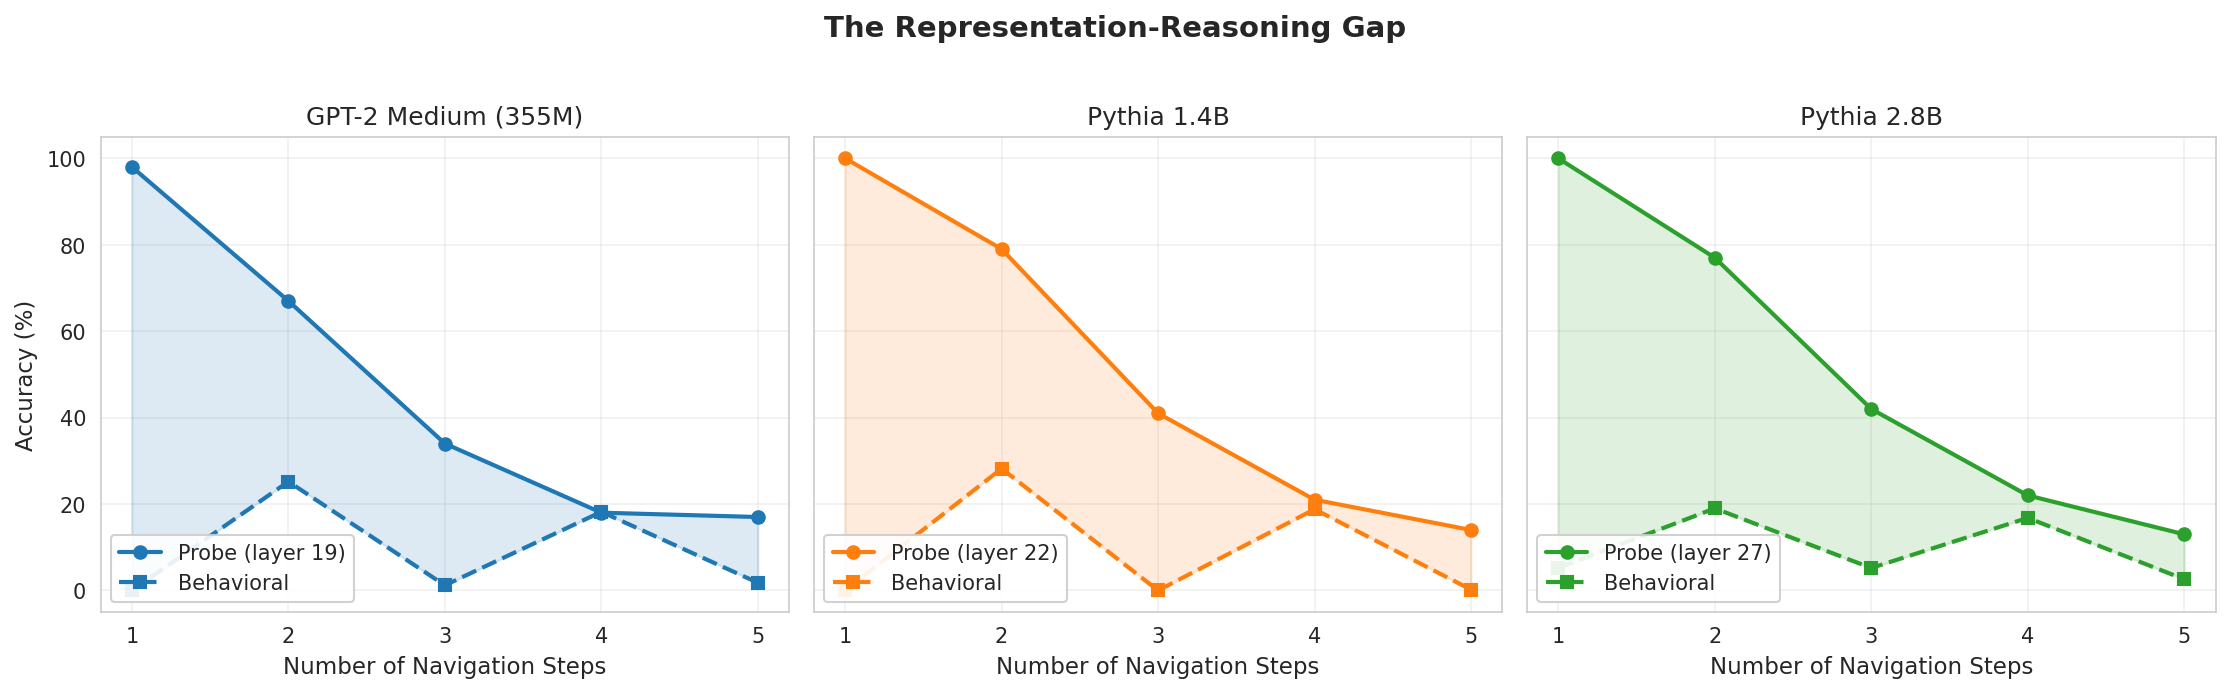

Saved: scissors_plot.pdf / .png


In [36]:
# Figure 1: Scissors Plot (Main Result)
fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 4.5), sharey=True)
if n_models == 1:
    axes = [axes]

for ax_idx, model_key in enumerate(available_models):
    ax = axes[ax_idx]
    result = all_results[model_key]
    behavioral = result["behavioral"]
    probing = result["probing"]
    peak = probing["peak_layer"]
    color = MODEL_COLORS[model_key]

    behav_accs = [behavioral[n]["accuracy"] * 100 for n in STEP_COUNTS]
    probe_accs = [probing["step_probe_acc"][peak, i] * 100 for i in range(len(STEP_COUNTS))]

    # Shade the gap
    ax.fill_between(STEP_COUNTS, behav_accs, probe_accs, alpha=0.15, color=color)

    # Lines
    ax.plot(STEP_COUNTS, probe_accs, '-o', color=color, linewidth=2, markersize=6,
            label=f'Probe (layer {peak})')
    ax.plot(STEP_COUNTS, behav_accs, '--s', color=color, linewidth=2, markersize=6,
            label='Behavioral')

    ax.set_xlabel('Number of Navigation Steps')
    ax.set_title(MODEL_CONFIGS[model_key]["description"])
    ax.set_xticks(STEP_COUNTS)
    ax.set_ylim(-5, 105)
    ax.yaxis.set_major_locator(mticker.MultipleLocator(20))
    ax.legend(loc='lower left', framealpha=0.9)
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel('Accuracy (%)')

fig.suptitle('The Representation-Reasoning Gap', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
fig.savefig(f"{FIGURES_DIR}/scissors_plot.pdf", bbox_inches='tight')
fig.savefig(f"{FIGURES_DIR}/scissors_plot.png", bbox_inches='tight')
plt.show()
print("Saved: scissors_plot.pdf / .png")

/tmp/ipython-input-3885672498.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


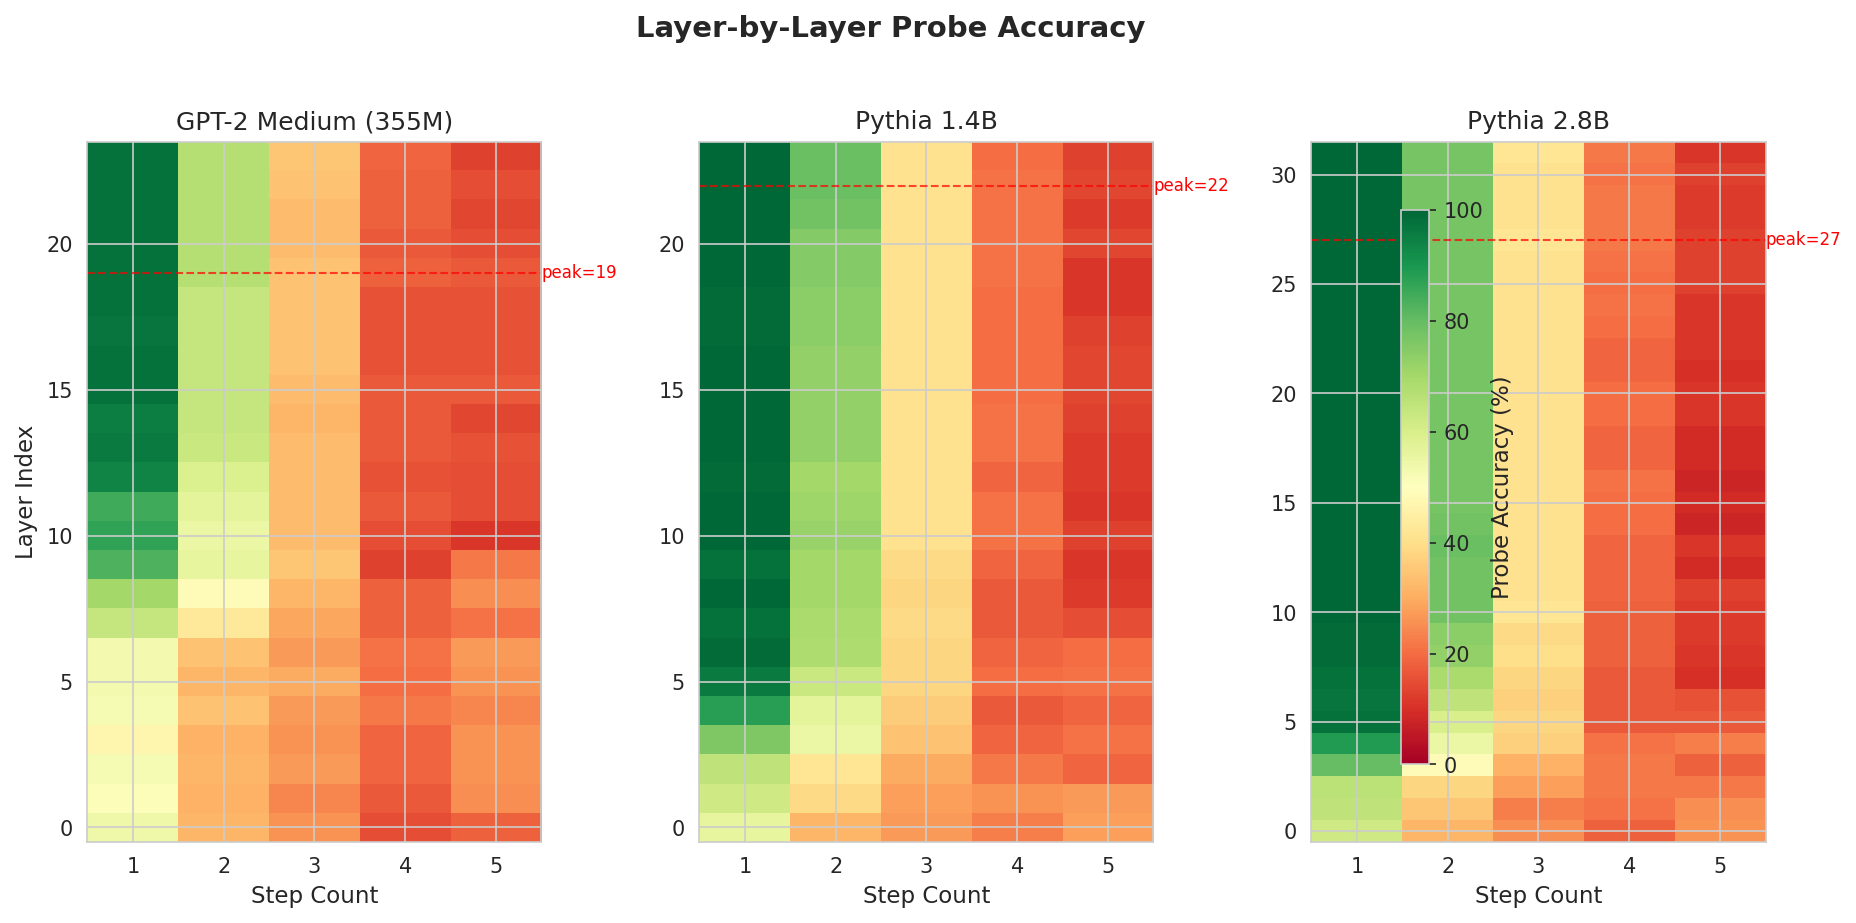

Saved: layer_heatmap.pdf / .png


In [37]:
# Figure 2: Layer-by-Layer Probe Accuracy Heatmap
fig, axes = plt.subplots(1, n_models, figsize=(4 * n_models, 6))
if n_models == 1:
    axes = [axes]

for ax_idx, model_key in enumerate(available_models):
    ax = axes[ax_idx]
    probing = all_results[model_key]["probing"]
    n_layers = MODEL_CONFIGS[model_key]["n_layers"]

    # step_probe_acc shape: (n_layers, 5)
    data = probing["step_probe_acc"] * 100  # convert to percentage

    im = ax.imshow(data, aspect='auto', cmap='RdYlGn', vmin=0, vmax=100,
                   origin='lower')
    ax.set_xticks(range(len(STEP_COUNTS)))
    ax.set_xticklabels(STEP_COUNTS)
    ax.set_xlabel('Step Count')
    ax.set_title(MODEL_CONFIGS[model_key]["description"])

    if ax_idx == 0:
        ax.set_ylabel('Layer Index')

    # Mark peak layer
    peak = probing["peak_layer"]
    ax.axhline(y=peak, color='red', linewidth=1, linestyle='--', alpha=0.7)
    ax.text(len(STEP_COUNTS) - 0.5, peak, f'peak={peak}', color='red', fontsize=8,
            va='center', ha='left')

# Shared colorbar
cbar = fig.colorbar(im, ax=axes, shrink=0.8, label='Probe Accuracy (%)')

fig.suptitle('Layer-by-Layer Probe Accuracy', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
fig.savefig(f"{FIGURES_DIR}/layer_heatmap.pdf", bbox_inches='tight')
fig.savefig(f"{FIGURES_DIR}/layer_heatmap.png", bbox_inches='tight')
plt.show()
print("Saved: layer_heatmap.pdf / .png")

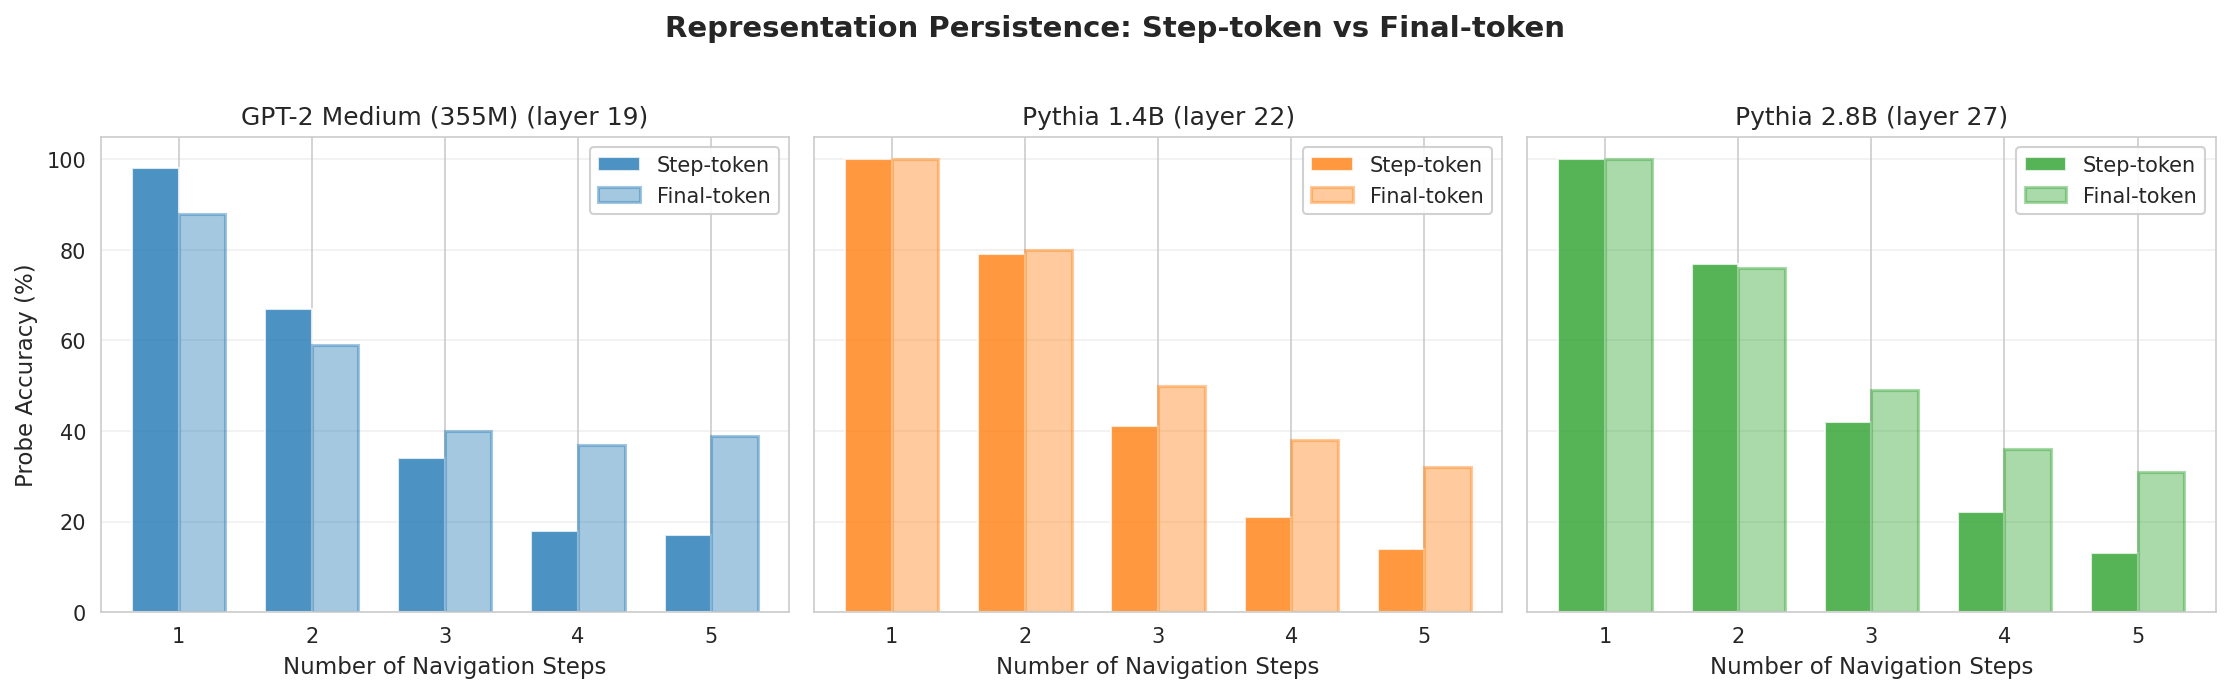

Saved: persistence.pdf / .png


In [38]:
# Figure 3: Representation Persistence
fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 4.5), sharey=True)
if n_models == 1:
    axes = [axes]

bar_width = 0.35
x = np.arange(len(STEP_COUNTS))

for ax_idx, model_key in enumerate(available_models):
    ax = axes[ax_idx]
    probing = all_results[model_key]["probing"]
    peak = probing["peak_layer"]
    color = MODEL_COLORS[model_key]

    step_accs = probing["step_probe_acc"][peak] * 100
    final_accs = probing["final_probe_acc"][peak] * 100

    ax.bar(x - bar_width/2, step_accs, bar_width, label='Step-token',
           color=color, alpha=0.8)
    ax.bar(x + bar_width/2, final_accs, bar_width, label='Final-token',
           color=color, alpha=0.4, edgecolor=color, linewidth=1.5)

    ax.set_xlabel('Number of Navigation Steps')
    ax.set_title(f"{MODEL_CONFIGS[model_key]['description']} (layer {peak})")
    ax.set_xticks(x)
    ax.set_xticklabels(STEP_COUNTS)
    ax.set_ylim(0, 105)
    ax.legend(loc='upper right', framealpha=0.9)
    ax.grid(True, alpha=0.3, axis='y')

axes[0].set_ylabel('Probe Accuracy (%)')

fig.suptitle('Representation Persistence: Step-token vs Final-token',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
fig.savefig(f"{FIGURES_DIR}/persistence.pdf", bbox_inches='tight')
fig.savefig(f"{FIGURES_DIR}/persistence.png", bbox_inches='tight')
plt.show()
print("Saved: persistence.pdf / .png")

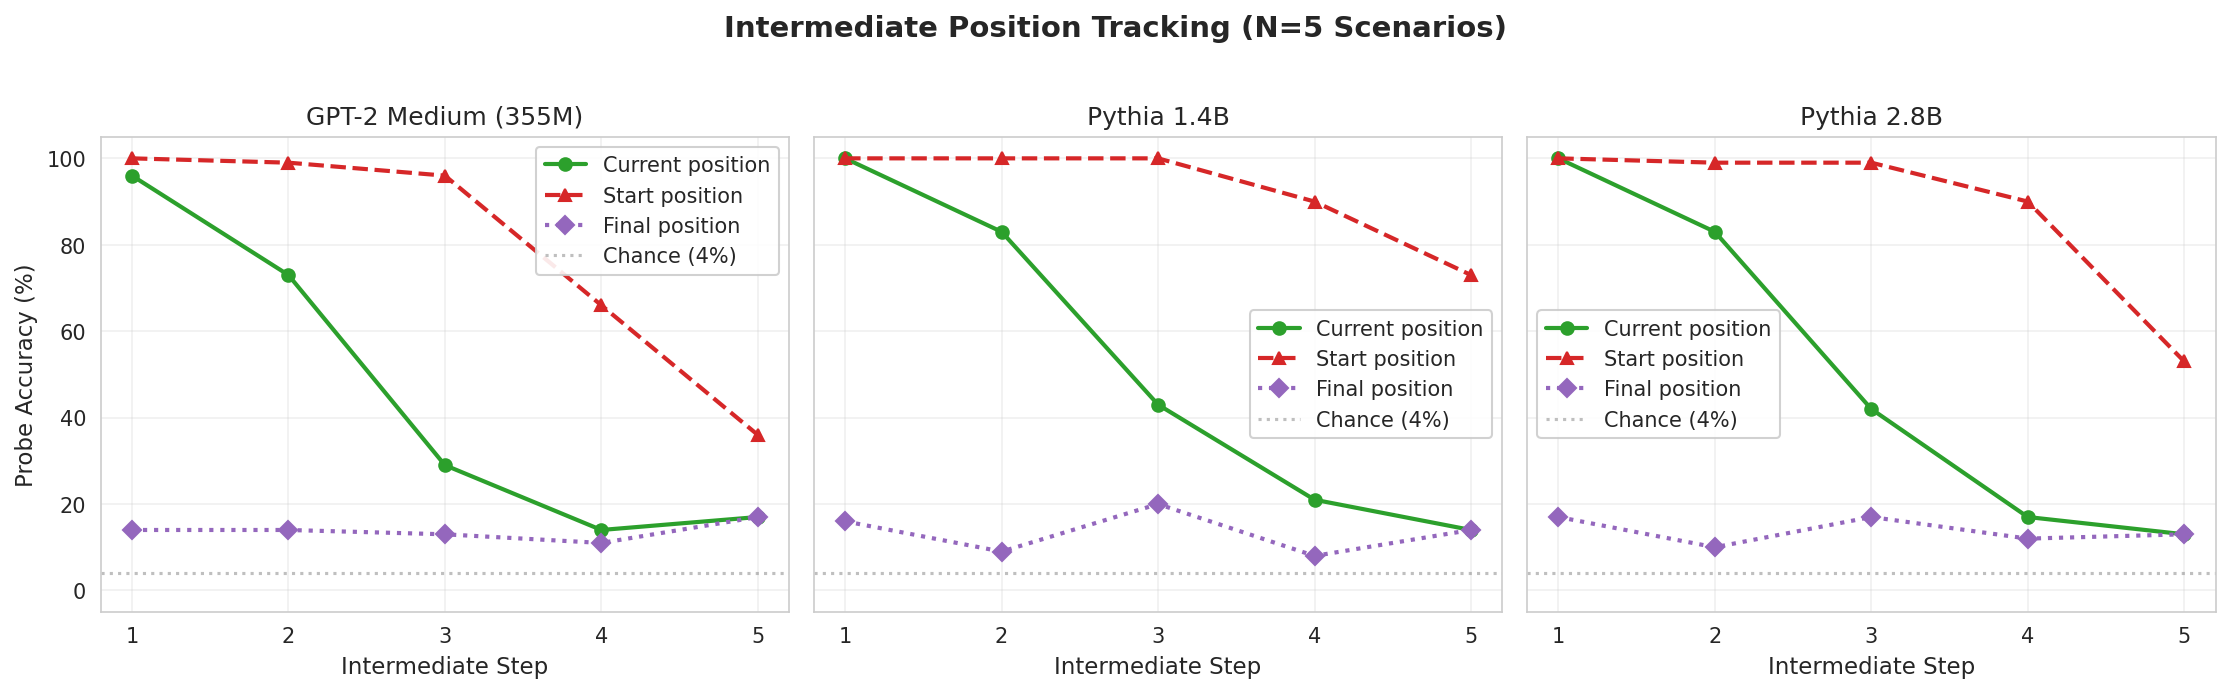

Saved: tracking.pdf / .png


In [39]:
# Figure 4: Intermediate Position Tracking (N=5)
fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 4.5), sharey=True)
if n_models == 1:
    axes = [axes]

steps_x = list(range(1, 6))

for ax_idx, model_key in enumerate(available_models):
    ax = axes[ax_idx]
    tracking = all_results[model_key]["tracking"]

    ax.plot(steps_x, [a * 100 for a in tracking["current_accs"]], '-o',
            color='#2ca02c', linewidth=2, markersize=6, label='Current position')
    ax.plot(steps_x, [a * 100 for a in tracking["start_accs"]], '--^',
            color='#d62728', linewidth=2, markersize=6, label='Start position')
    ax.plot(steps_x, [a * 100 for a in tracking["final_accs"]], ':D',
            color='#9467bd', linewidth=2, markersize=6, label='Final position')

    # Random baseline
    ax.axhline(y=4.0, color='gray', linestyle=':', alpha=0.5, label='Chance (4%)')

    ax.set_xlabel('Intermediate Step')
    ax.set_title(MODEL_CONFIGS[model_key]["description"])
    ax.set_xticks(steps_x)
    ax.set_ylim(-5, 105)
    ax.legend(loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel('Probe Accuracy (%)')

fig.suptitle('Intermediate Position Tracking (N=5 Scenarios)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
fig.savefig(f"{FIGURES_DIR}/tracking.pdf", bbox_inches='tight')
fig.savefig(f"{FIGURES_DIR}/tracking.png", bbox_inches='tight')
plt.show()
print("Saved: tracking.pdf / .png")

In [40]:
print("\n" + "="*60)
print("ALL DONE")
print("="*60)
print(f"\nModels processed: {[k for k, v in all_results.items() if v is not None]}")
print(f"Models skipped:   {[k for k, v in all_results.items() if v is None]}")
print(f"\nFigures saved to: {FIGURES_DIR}/")
for fname in ['scissors_plot', 'layer_heatmap', 'persistence', 'tracking']:
    for ext in ['pdf', 'png']:
        path = f"{FIGURES_DIR}/{fname}.{ext}"
        if os.path.exists(path):
            size_kb = os.path.getsize(path) / 1024
            print(f"  {path} ({size_kb:.0f} KB)")


ALL DONE

Models processed: ['gpt2-medium', 'pythia-1.4b', 'pythia-2.8b']
Models skipped:   []

Figures saved to: paper/figures/
  paper/figures/scissors_plot.pdf (27 KB)
  paper/figures/scissors_plot.png (282 KB)
  paper/figures/layer_heatmap.pdf (70 KB)
  paper/figures/layer_heatmap.png (160 KB)
  paper/figures/persistence.pdf (26 KB)
  paper/figures/persistence.png (153 KB)
  paper/figures/tracking.pdf (29 KB)
  paper/figures/tracking.png (333 KB)
